# Power & Language - Topic Model experiments

- [Data @OSF](https://osf.io/dwnxt/?view_only=e75faa4f54244361aa198e257b4fecf9)

In [ ]:
%%bash
pip install pandas numpy \
            scikit-learn
pip install gensim
pip install --upgrade spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Download data

In [ ]:
%%bash
curl -s -L -o osf-files.zip 'https://files.de-1.osf.io/v1/resources/dwnxt/providers/osfstorage/?view_only=e75faa4f54244361aa198e257b4fecf9&zip='
unzip osf-files.zip

Archive:  osf-files.zip
  inflating: Online Supplement.pdf   
  inflating: Mini Meta/Mini Meta-analysis.xlsx  
  inflating: Pilot Study/Data Pilot Study.xlsx  
  inflating: Pilot Study/Descriptions.pdf  
  inflating: Pilot Study/Data Pilot Study.sav  
  inflating: Study 2/Data Study 2.xlsx  
  inflating: Study 2/Data Study 2.sav  
  inflating: Study 2/Disattenuated Correlations Study 2.xlsx  
  inflating: Study 2/Syntax SOA Single Judge Study 2.sps  
  inflating: Study 2/Syntax Sensitivity Study 2.sps  
  inflating: Study 2/Syntax Consensus Study 2.sps  
  inflating: Study 2/Sensitivity Study 2.sav  
  inflating: Study 2/SOA Single Judge Study 2.sav  
  inflating: Study 2/Sensitivity Single Rater Study 2.sav  
  inflating: Study 1/Data Study 1.xlsx  
  inflating: Study 1/Syntax Sensitivity Study 1.sps  
  inflating: Study 1/SOA Single Judge Study 1.sav  
  inflating: Study 1/Syntax Consensus Study 1.sps  
  inflating: Study 1/Disattenuated Correlations Study 1.xlsx  
  inflating: Study

Prepare language models  
You may need to restart colab/jupyter kernel (python runtime) the first time to get them to work.

In [ ]:
! python -m spacy download de_core_news_sm
! python -m spacy download de_dep_news_trf

2022-10-17 11:58:34.951104: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.6 MB 7.3 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
2022-10-17 11:58:51.017173: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 412.8 MB 25 kB/s 
     |████████████████████████████████| 53 kB 1.8 MB/s 
     |████████████████████████████████| 4.7 MB 13.4 MB/s 
     |████████████████████████████████| 1.1 MB 64.7 MB/s 
     |████████████████████████████████| 163 kB 68.2 MB/s 
     |████████████████████████

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
import re

import numpy as np
import pandas as pd

import gensim
import nltk
import spacy

In [ ]:
import spacy
    
import de_core_news_sm
import de_dep_news_trf

nlp = de_core_news_sm.load()
nlp = de_dep_news_trf.load()

#nlp = spacy.load("de_core_news_sm")
#nlp = spacy.load("de_dep_news_trf")

## Load study data

In [ ]:
def load_study1():
    df_study1 = pd.read_excel("Study 1/Data Study 1.xlsx")
    #print(df_study1.columns.to_list())

    # just keep useful columns
    df_study1 = df_study1[[
        # id
        "ID",
        # raw text
        "SourceB",
        # other meta
        "Alter", "Geschlecht",
        # self-evaluation (mean)
        "Power_mean", "Dom_mean", "Pres_mean",
        # outside-evaluation (mean)
        "Power_F", "Dom_F", "Pres_F"
    ]]

    # rename columns
    df_study1.rename(columns={
        "SourceB": "text", "Alter": "age", "Geschlecht": "gender",
        "Power_mean": "power", "Dom_mean": "dominance", "Pres_mean": "prestige",
        "Power_F": "power_f", "Dom_F": "dominance_f", "Pres_F": "prestige_f",
    }, inplace=True)
    
    return df_study1


def load_study2():
    df_study2 = pd.read_excel("Study 2/Data Study 2.xlsx")
    #print(df_study2.columns.to_list())

    # just keep useful columns
    df_study2 = df_study2[[
        # id
        "ID",
        # raw text
        "SourceA",
        # other meta
        "Alter", "Geschlecht",
        # self-evaluation (mean)
        "Power_means", "Dominanz_means", "Prestige_means",
        # outside-evaluation (mean)
        "Power_Fremdgesamt_means", "Dominanz_Fremdgesamt_means", "Prestige_Fremdgesamt_means",
        # WP?
        #"WP_means",, "WP_Fremdgesamt_means",
    ]]

    # rename columns
    df_study2.rename(columns={
        "SourceA": "text", "Alter": "age", "Geschlecht": "gender",
        "Power_means": "power", "Dominanz_means": "dominance", "Prestige_means": "prestige",
        "Power_Fremdgesamt_means": "power_f", "Dominanz_Fremdgesamt_means": "dominance_f", "Prestige_Fremdgesamt_means": "prestige_f",
        "WP_means": "wp", "WP_Fremdgesamt_means": "wp_f",
    }, inplace=True)

    return df_study2

In [ ]:
#df_study1 = load_study1()
#df_study1.head()

In [ ]:
#df_study2 = load_study2()
#df_study2.head()

## Cleanup data

In [ ]:
def nlpize(df, nlp_fn):
    return df.map(nlp_fn)


def clean(df, stopwords=False, alpha=False, punctuation=True):
    # filter out stopwords
    if stopwords:
        df = df.map(lambda doc: list(filter(lambda tok: not tok.is_stop, doc)))

    # filter alphanumerical
    if alpha:
        df = df.map(lambda doc: list(filter(lambda tok: tok.is_alpha, doc)))

    # filter out punctuation
    if punctuation:
        df = df.map(lambda doc: list(filter(lambda tok: tok.pos_ not in ("PUNCT"), doc)))

    return df


def remove_punct(df):
    return df.map(lambda x: re.sub(r"[,\.!?]", '', x))


def lowercase_text(df):
    return df.map(lambda x: x.lower())


def get_text_by_pos(df, pos_list=("NOUN",), lemma=False, join=True):
    # filter each token by correct pos tag
    if pos_list:
      df = df.map(lambda x: list(filter(lambda tok: tok.pos_ in pos_list, x)))

    # convert tokens back to strings
    #df = df.map(lambda x: " ".join(map(str, x)))
    if lemma:
        df = df.map(lambda x: " ".join(map(lambda tok: tok.lemma_, x)))
    else:
        df = df.map(lambda x: " ".join(map(lambda tok: tok.text, x)))
    
    # concat to single text
    if not join:
        return df

    return ','.join(df.values.tolist())

## Analyze

### Look at the data

In [ ]:
df_study1t = pd.read_excel("Study 1/Data Study 1.xlsx")

df_study1t[["Power_mean", "Dom_mean", "Pres_mean"]].describe()

cols = [
    'Power1', 'Power2', 'Power3', 'Power4', 'Power5', 'Power6', 'Power7', 'Power8',
    'Dom1', 'Dom2', 'Dom3', 'Dom4', 'Dom5', 'Dom6', 'Dom7', 'Dom8',
    'Pres1', 'Pres2', 'Pres3', 'Pres4', 'Pres5', 'Pres6', 'Pres7', 'Pres8', 'Pres9',
]
df_study1t[cols].describe()
# values from 1..7 / -9?

,Power1,Power2,Power3,Power4,Power5,Power6,Power7,Power8,Dom1,Dom2,...,Dom8,Pres1,Pres2,Pres3,Pres4,Pres5,Pres6,Pres7,Pres8,Pres9
count,200.00000,200.000000,200.000000,200.000000,200.000000,200.00000,200.000000,200.000000,200.000000,200.000000,...,200.00000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,5.55500,4.510000,4.785000,5.260000,3.555000,5.23500,5.520000,5.415000,2.885000,3.025000,...,2.61000,5.145000,4.875000,3.780000,5.815000,5.635000,5.040000,5.465000,5.085000,5.260000
std,1.17639,2.286051,1.275504,1.349632,1.458634,1.65938,1.341116,1.400924,1.736911,1.454287,...,1.72417,0.953162,1.251883,2.096084,1.523938,0.967707,1.251492,1.529862,1.643558,1.760082
min,2.00000,-9.000000,1.000000,2.000000,1.000000,-9.00000,1.000000,1.000000,-9.000000,1.000000,...,1.00000,2.000000,1.000000,-9.000000,-9.000000,1.000000,1.000000,-9.000000,-9.000000,-9.000000
25%,5.00000,3.000000,4.000000,5.000000,2.000000,5.00000,5.000000,5.000000,2.000000,2.000000,...,1.00000,5.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.000000
50%,6.00000,5.000000,5.000000,6.000000,4.000000,6.00000,6.000000,6.000000,3.000000,3.000000,...,2.00000,5.000000,5.000000,4.000000,6.000000,6.000000,5.000000,6.000000,5.000000,6.000000
75%,6.00000,6.000000,6.000000,6.000000,5.000000,6.00000,7.000000,6.000000,4.000000,4.000000,...,4.00000,6.000000,6.000000,5.000000,7.000000,6.000000,6.000000,6.000000,6.000000,6.000000
max,7.00000,7.000000,7.000000,7.000000,7.000000,7.00000,7.000000,7.000000,7.000000,7.000000,...,7.00000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000


In [ ]:
df_study1t = load_study1()
df_study1t.drop(columns=["ID", "gender"]).describe()

,age,power,dominance,prestige,power_f,dominance_f,prestige_f
count,172.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,46.558140,5.012054,3.082321,5.170764,4.507000,3.302625,4.850111
std,15.028709,0.987213,1.077791,0.771297,0.904578,0.909609,0.676481
min,18.000000,1.625000,1.000000,2.555556,2.275000,1.350000,2.622222
25%,34.750000,4.500000,2.250000,4.666667,3.900000,2.600000,4.350000
50%,48.000000,5.125000,3.000000,5.111111,4.612500,3.250000,4.955556
75%,59.000000,5.750000,3.861607,5.777778,5.206250,3.800000,5.333333
max,78.000000,6.750000,6.375000,6.777778,6.275000,6.125000,6.222222


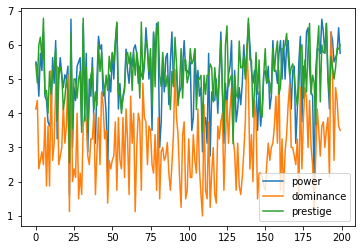

In [ ]:
df_study1t[["power", "dominance", "prestige"]].plot(kind='line')

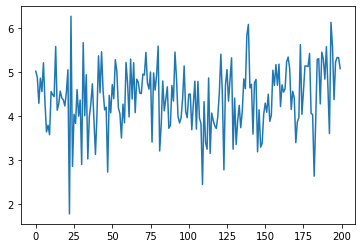

In [ ]:
df_study1t[["power", "dominance", "prestige"]].mean(axis=1).plot(kind='line')

### Load and preprocess data

In [ ]:
# load data
df_study1 = load_study1()
df_study2 = load_study2()

In [ ]:
df_study1.describe()

,ID,age,gender,power,dominance,prestige,power_f,dominance_f,prestige_f
count,200.000000,172.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,372.370000,46.558140,1.255000,5.012054,3.082321,5.170764,4.507000,3.302625,4.850111
std,113.637629,15.028709,0.436955,0.987213,1.077791,0.771297,0.904578,0.909609,0.676481
min,181.000000,18.000000,1.000000,1.625000,1.000000,2.555556,2.275000,1.350000,2.622222
25%,272.500000,34.750000,1.000000,4.500000,2.250000,4.666667,3.900000,2.600000,4.350000
50%,374.000000,48.000000,1.000000,5.125000,3.000000,5.111111,4.612500,3.250000,4.955556
75%,477.250000,59.000000,2.000000,5.750000,3.861607,5.777778,5.206250,3.800000,5.333333
max,558.000000,78.000000,2.000000,6.750000,6.375000,6.777778,6.275000,6.125000,6.222222


In [ ]:
%%time
# tokenize, postag, ...
df_study1["text_spacy_doc"] = nlpize(df_study1["text"], nlp)
df_study2["text_spacy_doc"] = nlpize(df_study2["text"], nlp)

/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


CPU times: user 4min 9s, sys: 2.4 s, total: 4min 11s
Wall time: 4min 12s


In [ ]:
# remove punctuation
df_study1["text_spacy_doc_filtered"] = clean(df_study1["text_spacy_doc"], stopwords=False, alpha=False, punctuation=True)
df_study2["text_spacy_doc_filtered"] = clean(df_study2["text_spacy_doc"], stopwords=False, alpha=False, punctuation=True)

In [ ]:
# take raw text `tok.text` instead of lemma `tok.lemma_`
df_study1["tokens"] = df_study1["text_spacy_doc_filtered"].map(lambda doc: list(map(lambda tok: tok.text, doc)))
df_study2["tokens"] = df_study2["text_spacy_doc_filtered"].map(lambda doc: list(map(lambda tok: tok.text, doc)))
# convert to plain string
df_study1["tokens"] = df_study1["tokens"].map(lambda doc: list(map(str, doc)))
df_study2["tokens"] = df_study2["tokens"].map(lambda doc: list(map(str, doc)))

In [ ]:
# concat both studies
#docs = pd.concat([df_study1["tokens"], df_study2["tokens"]], ignore_index=True)
#docs_raw = docs.map(lambda doc: " ".join(doc))

### Create features

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

import sklearn.dummy
from sklearn import svm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics
import sklearn.metrics

In [ ]:
df_study1["text_cleaned"] = df_study1["tokens"].map(lambda doc: " ".join(doc))

X = df_study1["text_cleaned"].values
y = df_study1[["power", "dominance", "prestige"]].values
print("shape X: ", X.shape)
print("shape y: ", y.shape)

shape X:  (200,)
shape y:  (200, 3)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3, shuffle=False)

In [ ]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_train_counts.shape

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

X_test_counts = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
X_test_tfidf.shape

(60, 1971)

In [ ]:
vectorizer = TfidfVectorizer(max_features=2500, min_df=2, max_df=0.8)
vectorizer = TfidfVectorizer(max_features=2500, min_df=2, max_df=0.8, binary=True)
vectorizer = TfidfVectorizer(max_features=2500, min_df=2, max_df=0.8, binary=True, idf=False, normalization=False) 
vectorizer.fit(X)

X_train_tfidf = processed_features = vectorizer.transform(X_train)
X_test_tfidf = processed_features = vectorizer.transform(X_test)
X_train_tfidf.shape, X_test_tfidf.shape

((140, 843), (60, 843))

In [ ]:
X_train_tfidf.todense()

matrix([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.2314922,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        ...,
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ]])

In [ ]:
# TFIDF features binarisieren
# TfidfVectorizer -> binary=True

### Labels

In [ ]:
y_pow = y_train[:,0]
y_dom = y_train[:,1]
y_pre = y_train[:,2]

y_true = y_pow

### Dummy regressor (just statistics/mean, ...)

- regr score: best 1.0, worst 0.0
- r2: best 1.0, constant model 0.0, can be negative
- mse: best is 0.0

In [ ]:
regr = sklearn.dummy.DummyRegressor(strategy="mean")

y_true = y_train[:,0]
regr.fit(X_train_tfidf, y_true)

y_pred = regr.predict(X_train_tfidf)
print("score:", regr.score(X_train_tfidf, y_true))
print("mse:", sklearn.metrics.mean_squared_error(y_true, y_pred))
print("r2: ", sklearn.metrics.r2_score(y_true, y_pred))

y_pred = regr.predict(X_test_tfidf)
y_true = y_test[:,0]

print("score:", regr.score(X_test_tfidf, y_true))
print("mse:", sklearn.metrics.mean_squared_error(y_true, y_pred))
print("r2: ", sklearn.metrics.r2_score(y_true, y_pred))

#for t, p in zip(y_true, y_pred):
#  print(f" {t:2.2f}  {p:2.2f}")

score: 0.0
mse: 0.980376275510204
r2:  0.0
score: -0.1220062414201839
mse: 0.9767038690476187
r2:  -0.1220062414201839


### Regressors

In [ ]:
y_pow = y_train[:,0]
y_dom = y_train[:,1]
y_pre = y_train[:,2]

y_true = y_pow

regr = svm.SVR()
regr.fit(X_train_tfidf, y_true)

y_pred = regr.predict(X_train_tfidf)

print("score:", regr.score(X_train_tfidf, y_true))
print("mse:", sklearn.metrics.mean_squared_error(y_true, y_pred))
print("r2: ", sklearn.metrics.r2_score(y_true, y_pred))

score: 0.7776080667530352
mse: 0.21802777522017328
r2:  0.7776080667530352


In [ ]:
y_pred = regr.predict(X_test_tfidf)
y_true = y_test[:,0]
# np.vstack([y_pred, y_true])

print("score:", regr.score(X_test_tfidf, y_true))
print("mse:", sklearn.metrics.mean_squared_error(y_true, y_pred))
print("r2: ", sklearn.metrics.r2_score(y_true, y_pred))

score: -0.07219415251760619
mse: 0.9333425594929495
r2:  -0.07219415251760619


## Other stuff